## 1. Loading the necessary packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 2. Reading the Data and renaming the columns

In [5]:
data = pd.read_excel("data.xlsx")

# Convert 'Date' column to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Rename columns if needed for convenience
data.rename(
    columns={
        'Crude Oil (Dollars per Barrel)': 'Crude',
        'Retail Gasoline Prices (Dollars per Gallon)': 'Gasoline'
    },
    inplace=True
)

# Set date as index (monthly data)
data.set_index('Date', inplace=True)

print(data.head())
print(data.info())
print("Missing values by column:\n", data.isnull().sum())

            Crude  Gasoline  \
Date                          
1993-04-01  20.25   1.07800   
1993-05-01  19.95   1.10040   
1993-06-01  19.09   1.09725   
1993-07-01  17.89   1.07775   
1993-08-01  18.01   1.06160   

            U.S. Percent Utilization of Refinery Operable Capacity %  \
Date                                                                   
1993-04-01                                               85.5          
1993-05-01                                               89.4          
1993-06-01                                               92.4          
1993-07-01                                               91.9          
1993-08-01                                               89.1          

            Avg of US Ending Stock of Motor Gasoline  \
Date                                                   
1993-04-01                                 185153.20   
1993-05-01                                 183072.25   
1993-06-01                                 187001.50 

## 3. Splitting the data into training and testing

Since the LSTM model needs a lookback periods, for this particular analysis we have taken the data uptill 2022 as the testing data and two years data of 2023 and 2024 as the training data.

With a lookback periods of 12, the LSTM model will properly forecast the spread and gasoline prices of 2024.

In [6]:
train = data.loc['1993-04-01':'2022-12-01'].copy()
test  = data.loc['2023-01-01':'2024-11-01'].copy()

# Separate into two columns for convenience
train_crude = train['Crude']
train_gasoline = train['Gasoline']
test_crude = test['Crude']
test_gasoline = test['Gasoline']

## 4. Scaling the data

We need to ensure the gasoline and crude prices are on the same scaling for accurate forecasts

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# We will scale both columns (Crude, Gasoline) together so we can feed them into an LSTM
train_array = train[['Crude','Gasoline']].values
test_array  = test[['Crude','Gasoline']].values

# Fit scaler on the train set, then transform both train and test
scaler.fit(train_array)
train_scaled = scaler.transform(train_array)
test_scaled  = scaler.transform(test_array)

## 5. Creating the lookback seqeuence for LSTM

In [8]:
def create_sequences(data_2d, lookback=12):
    """
    data_2d: NumPy array of shape (n_samples, 2) => [Crude, Gasoline].
    lookback: How many past timesteps to include.

    Returns:
      X: 3D array for LSTM of shape (num_sequences, lookback, num_features=2)
      y: 1D array of shape (num_sequences,) for Gasoline(t+1).
    """
    X, y = [], []
    for i in range(len(data_2d) - lookback):
        # Past "lookback" rows (Crude, Gasoline)
        seq_x = data_2d[i : i + lookback]
        # We want to predict the Gasoline price at time i+lookback
        seq_y = data_2d[i + lookback, 1]  # column index 1 => Gasoline
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

lookback = 12
X_train, y_train = create_sequences(train_scaled, lookback=lookback)
X_test,  y_test  = create_sequences(test_scaled, lookback=lookback)

print("X_train shape:", X_train.shape)  # (num_samples, 12, 2)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (345, 12, 2)
y_train shape: (345,)
X_test shape: (11, 12, 2)
y_test shape: (11,)


## 6. Training the LSTM model

In [15]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(lookback, 2)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # predict next month's Gasoline price (scaled)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,       # Increase if needed
    batch_size=16,   # Adjust as needed
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0590 - val_loss: 0.0200
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0191
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083 - val_loss: 0.0247
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0208
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0277
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - val_loss: 0.0166
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0114
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0098
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - val_loss: 0.0095
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0169
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0181
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_lo

##  7. Making gasoline price predictions for 2024

In [16]:
y_pred_scaled = model.predict(X_test)

# 7.2 Inverse transform the scaled predictions and actual values
# We only have predictions for Gasoline (the second column).
# We can build a dummy array to inverse_transform properly.
# Inverse transform expects shape (n_samples, 2).
# We'll put the predicted Gasoline in column 1, and "dummy" in column 0.
dummy_crude = np.zeros_like(y_pred_scaled)  # just zeros for the "Crude" column
pred_combined = np.hstack((dummy_crude, y_pred_scaled))

# For actual (test) values, we also have them in scaled form, y_test, representing Gasoline only.
dummy_crude_test = np.zeros_like(y_test.reshape(-1,1))
actual_combined = np.hstack((dummy_crude_test, y_test.reshape(-1,1)))

# Inverse scaling
pred_inv = scaler.inverse_transform(pred_combined)
y_pred_inv = pred_inv[:,1]  # predicted Gasoline (in original scale)

actual_inv = scaler.inverse_transform(actual_combined)
y_test_inv = actual_inv[:,1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


## 8. Plotting the actual vs forecasted price of gasoline for the year 2024


In [17]:
test_dates = test.index[lookback:]  # align with how we created sequences
results_df = pd.DataFrame({
    'Date': test_dates,
    'Gasoline_Actual': y_test_inv,
    'Gasoline_Predicted': y_pred_inv
})
results_df.set_index('Date', inplace=True)

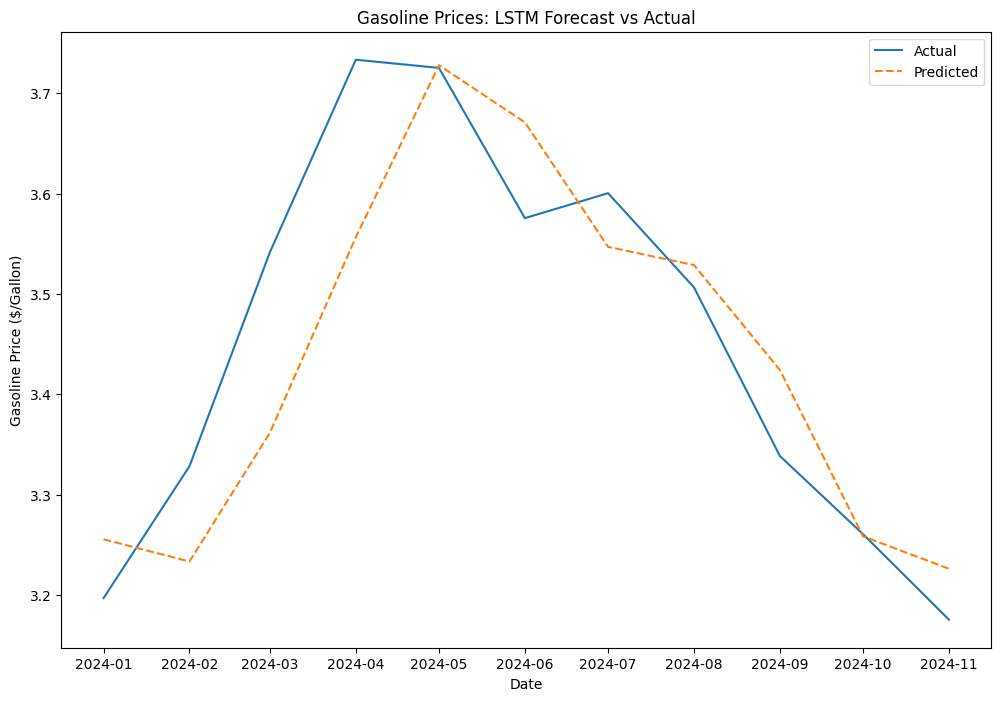

In [18]:
plt.figure(figsize=(12,8))
plt.plot(results_df.index, results_df['Gasoline_Actual'], label='Actual')
plt.plot(results_df.index, results_df['Gasoline_Predicted'], label='Predicted', linestyle='--')
plt.title("Gasoline Prices: LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gasoline Price ($/Gallon)")
plt.legend()
plt.show()

## 9. Creating the forecasted vs actual spread between gasoline and crude

The spread is calculated by subtracting the price of crude oil from the price

of gasoline. We add a beta term to normalize the crude oil values to bring the crude oil and gasoline on the same scale.

We calculate the actual spread using the actual values of gasoline and the predicted spread using the predicted price of gasoline from our LSTM model.

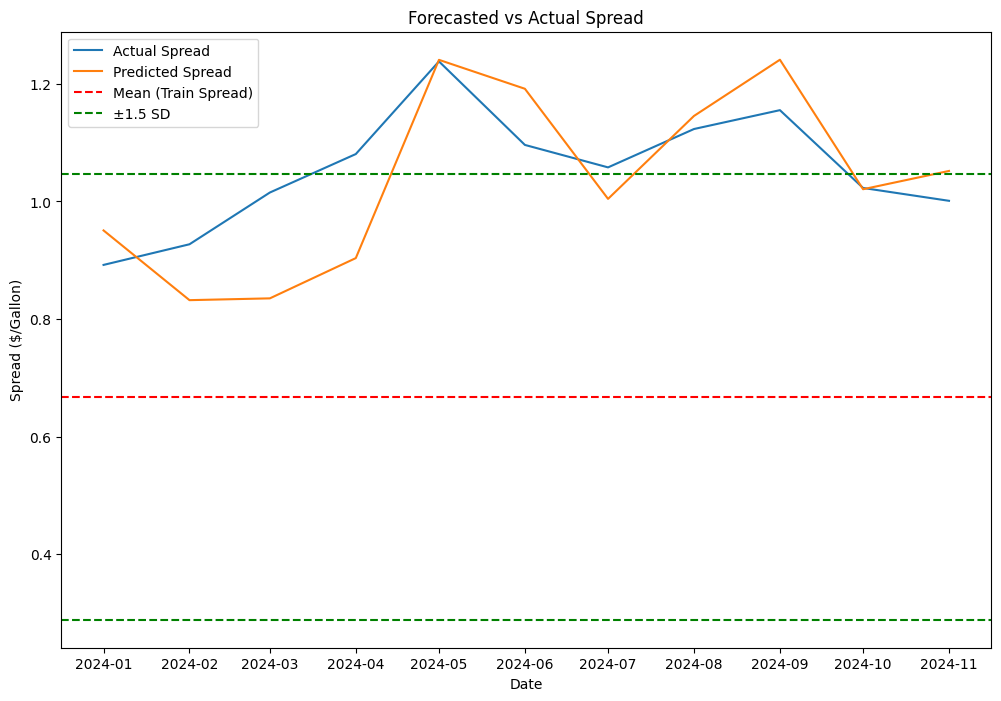

In [19]:
test_crude_aligned = test_crude.iloc[lookback:].copy()

# Build a DataFrame for final analysis
analysis_df = pd.DataFrame({
    'Gasoline_Actual': results_df['Gasoline_Actual'],
    'Gasoline_Predicted': results_df['Gasoline_Predicted'],
    'Crude_Actual': test_crude_aligned
})

# Spread (predicted Gasoline - actual Crude)
analysis_df['Predicted_Spread'] = analysis_df['Gasoline_Predicted'] - (0.031081434515637156*analysis_df['Crude_Actual'])
analysis_df['Actual_Spread'] = analysis_df['Gasoline_Actual'] - (0.031081434515637156*analysis_df['Crude_Actual'])

# For threshold-based strategy, we need historical mean & std of "spread" from the *training* period
# Let's define a training spread for reference: (Gasoline - Crude) in the training set
train_spread = train_gasoline - (0.031081434515637156*train_crude)
historical_mean = train_spread.mean()
historical_sd   = train_spread.std()

analysis_df
plt.figure(figsize=(12,8))
plt.plot(analysis_df.index, analysis_df['Actual_Spread'], label='Actual Spread')
plt.plot(analysis_df.index, analysis_df['Predicted_Spread'], label='Predicted Spread')
plt.axhline(historical_mean, linestyle='--', color='red', label='Mean (Train Spread)')
plt.axhline(historical_mean + 1.5*historical_sd, linestyle='--', color='green', label='±1.5 SD')
plt.axhline(historical_mean - 1.5*historical_sd, linestyle='--', color='green')
plt.title("Forecasted vs Actual Spread")
plt.xlabel("Date")
plt.ylabel("Spread ($/Gallon)")
plt.legend()
plt.show()

In [20]:
residuals = results_df['Gasoline_Actual'] - results_df['Gasoline_Predicted']
mae  = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
mape = np.mean(np.abs(residuals / results_df['Gasoline_Actual'])) * 100
r2   = np.corrcoef(results_df['Gasoline_Actual'], results_df['Gasoline_Predicted'])[0,1]**2

print("\nLSTM Forecast Accuracy:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")
print(f"R^2  = {r2:.4f}")


LSTM Forecast Accuracy:
MAE  = 0.0748
RMSE = 0.0947
MAPE = 2.15%
R^2  = 0.7676


## 10. Testing our trading strategy

The goal of forecasting the spread, is to create buy and sell signals for gasoline prices. We determine the Z-Score values using our predicted spread. When the predicted spread goes above the upper Z-Score threshold, that implies a sell signal on gasoline. When the predicted spread goes below the lower Z-Score threshold, that implies a buy signal on gasoline.

We use the signals generated by the predicted spread from our LSTM models on the actual gasoline price of 2024 and calculate the amount of profit that our model would have made.

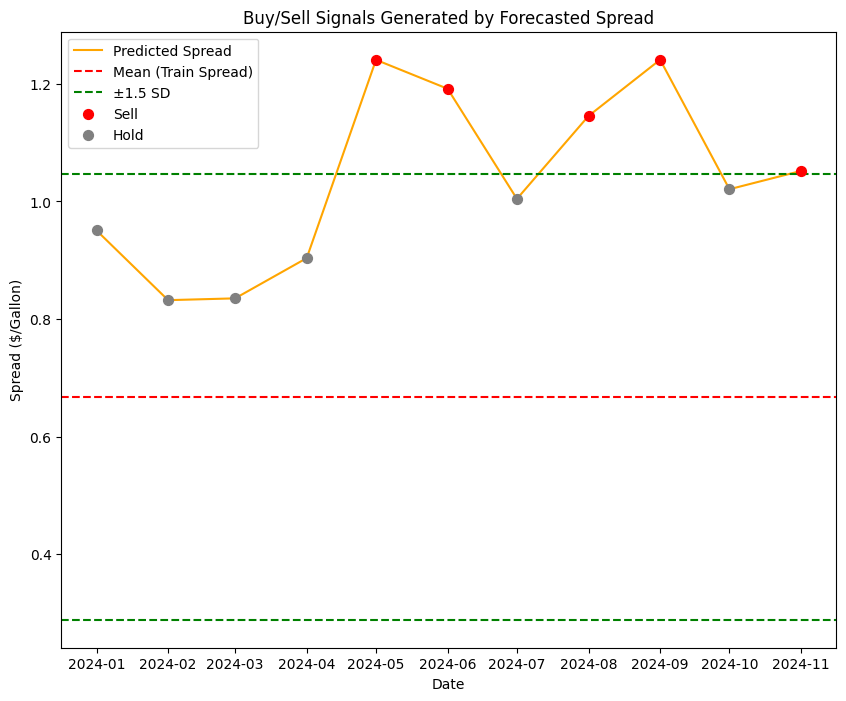

In [21]:
upper_threshold = historical_mean + 1.5 * historical_sd
lower_threshold = historical_mean - 1.5 * historical_sd

# Create figure/axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the main line
ax.plot(
    analysis_df.index,
    analysis_df['Predicted_Spread'],
    color='orange',
    label='Predicted Spread'
)

# Plot horizontal lines (mean, ±1.5 SD)
ax.axhline(
    historical_mean,
    linestyle='--',
    color='red',
    label='Mean (Train Spread)'
)
ax.axhline(
    upper_threshold,
    linestyle='--',
    color='green',
    label='±1.5 SD'
)
ax.axhline(
    lower_threshold,
    linestyle='--',
    color='green'
)

# Split the data into above, below, and within threshold
above_threshold_df = analysis_df[analysis_df['Predicted_Spread'] > upper_threshold]
below_threshold_df = analysis_df[analysis_df['Predicted_Spread'] < lower_threshold]
within_threshold_df = analysis_df[
    (analysis_df['Predicted_Spread'] >= lower_threshold) &
    (analysis_df['Predicted_Spread'] <= upper_threshold)
]

# Plot each subset with a different color
ax.scatter(
    above_threshold_df.index,
    above_threshold_df['Predicted_Spread'],
    color='red',
    s=50,
    zorder=5,
    label='Sell'
)

ax.scatter(
    within_threshold_df.index,
    within_threshold_df['Predicted_Spread'],
    color='gray',
    s=50,
    zorder=5,
    label='Hold'
)

ax.set_title("Buy/Sell Signals Generated by Forecasted Spread")
ax.set_xlabel("Date")
ax.set_ylabel("Spread ($/Gallon)")
ax.legend()
plt.show()

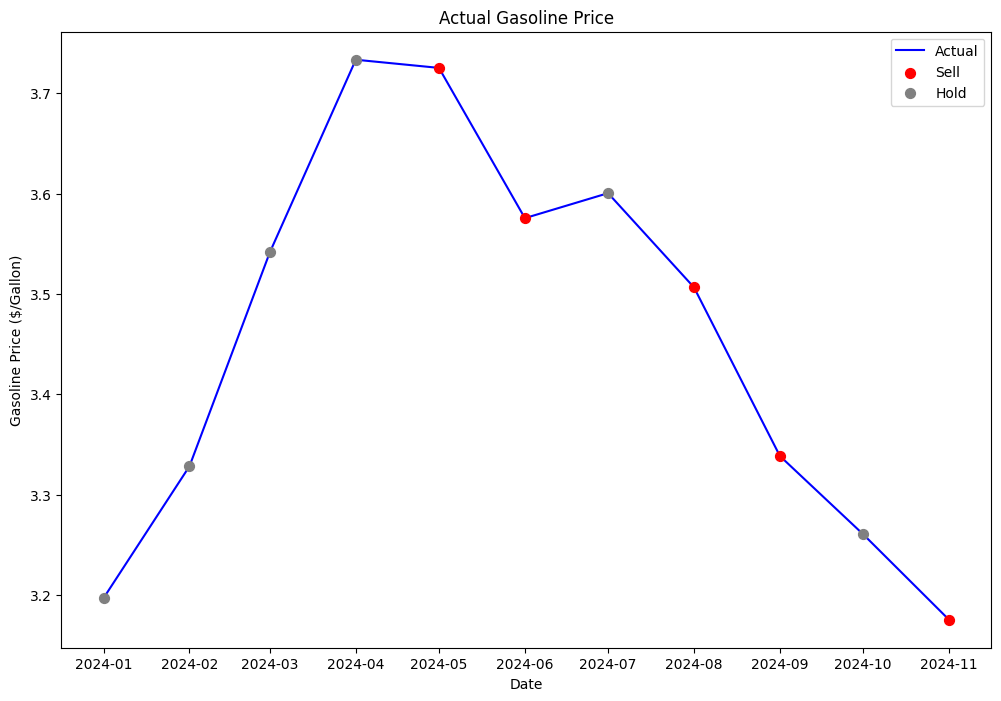

In [22]:
upper_threshold = historical_mean + 1.5 * historical_sd
lower_threshold = historical_mean - 1.5 * historical_sd

# --- 2) Identify above, below, within-threshold rows ---
above_threshold_df = analysis_df[analysis_df['Predicted_Spread'] > upper_threshold]
below_threshold_df = analysis_df[analysis_df['Predicted_Spread'] < lower_threshold]
within_threshold_df = analysis_df[
    (analysis_df['Predicted_Spread'] >= lower_threshold) &
    (analysis_df['Predicted_Spread'] <= upper_threshold)
]

# --- 3) Plot the Actual and Predicted lines ---
plt.figure(figsize=(12,8))
plt.plot(results_df.index, results_df['Gasoline_Actual'],
         label='Actual', color='blue')

# --- 4) Overlay the red/gray markers using the same index positions ---
#     Make sure 'results_df' and 'analysis_df' share the same index
#     or adjust the .loc[] as needed.

# Above threshold → red
plt.scatter(
    above_threshold_df.index,
    results_df.loc[above_threshold_df.index, 'Gasoline_Actual'],
    color='red',
    s=50,
    zorder=5,
    label='Sell'
)

# Within threshold → gray
plt.scatter(
    within_threshold_df.index,
    results_df.loc[within_threshold_df.index, 'Gasoline_Actual'],
    color='gray',
    s=50,
    zorder=5,
    label='Hold'
)

# --- 5) Final labeling & display ---
plt.title("Actual Gasoline Price")
plt.xlabel("Date")
plt.ylabel("Gasoline Price ($/Gallon)")
plt.legend()
plt.show()

In [23]:
analysis_df['Z_Score'] = (analysis_df['Predicted_Spread'] - historical_mean) / historical_sd

def signal_func(z):
    if z < -1.5:
        return "Buy"
    elif z > 1.5:
        return "Sell"
    else:
        return "Hold"

analysis_df['Signal'] = analysis_df['Z_Score'].apply(signal_func)

# Compute returns on next-period reversion
analysis_df['Gasoline_Next'] = analysis_df['Gasoline_Actual'].shift(-1)

def compute_return(row):
    if row['Signal'] == 'Buy':
        # Profit if spread goes up next period
        return (row['Gasoline_Next'] - row['Gasoline_Actual']) * 1000  # 1 contract = 1000 gallons
    elif row['Signal'] == 'Sell':
        # Profit if spread goes down next period
        return (row['Gasoline_Actual'] - row['Gasoline_Next']) * 1000
    else:
        return 0.0

analysis_df['Returns'] = analysis_df.apply(compute_return, axis=1)
total_profit = analysis_df['Returns'].sum()

analysis_df['Cumulative_Profit'] = analysis_df['Returns'].cumsum()

print(f"\nTotal Profit from LSTM Spread Strategy: ${total_profit:,.2f}")

analysis_df


Total Profit from LSTM Spread Strategy: $370.85


,Gasoline_Actual,Gasoline_Predicted,Crude_Actual,Predicted_Spread,Actual_Spread,Z_Score,Signal,Gasoline_Next,Returns,Cumulative_Profit
Date,,,,,,,,,,
2024-01-01,3.19680,3.255431,74.15,0.950743,0.892112,1.119039,Hold,3.32825,0.00,0.00
2024-02-01,3.32825,3.233227,77.25,0.832186,0.927209,0.649939,Hold,3.54150,0.00,0.00
2024-03-01,3.54150,3.361544,81.28,0.835245,1.015201,0.662042,Hold,3.73340,0.00,0.00
2024-04-01,3.73340,3.556489,85.35,0.903689,1.080600,0.932857,Hold,3.72525,0.00,0.00
2024-05-01,3.72525,3.727929,80.02,1.240793,1.238114,2.266702,Sell,3.57550,149.75,149.75
2024-06-01,3.57550,3.670980,79.77,1.191614,1.096134,2.072114,Sell,3.60040,-24.90,124.85
2024-07-01,3.60040,3.546860,81.80,1.004398,1.057939,1.331342,Hold,3.50650,0.00,124.85
2024-08-01,3.50650,3.528717,76.68,1.145393,1.123176,1.889226,Sell,3.33840,168.10,292.95
2024-09-01,3.33840,3.424155,70.24,1.240995,1.155240,2.267502,Sell,3.26050,77.90,370.85


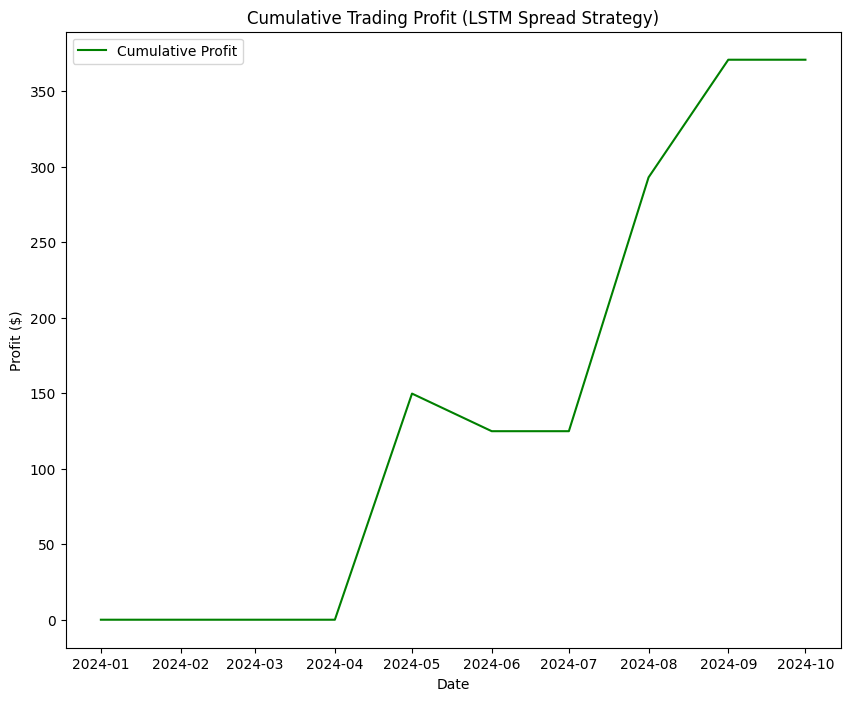

In [24]:
plt.figure(figsize=(10,8))
plt.plot(analysis_df.index, analysis_df['Cumulative_Profit'], color='green', label='Cumulative Profit')
plt.title("Cumulative Trading Profit (LSTM Spread Strategy)")
plt.xlabel("Date")
plt.ylabel("Profit ($)")
plt.legend()
plt.show()